In [330]:
import numpy as np
import matplotlib.pyplot as plt

In [331]:
# Policy parameterization: Softmax
# State value parameterization: Linear
# State feature vector representation: Fourier (as in HW2)

In [332]:
M = 3 # dimensionality of the fourier transform [2, 10]
# mean_policy_vector = np.ones(2*M+1)*0.05 #some non-zero vector

policy_params = np.ones((2*M+1,2))*0.01
value_params = np.ones(2*M+1)*0.01

softmax_sigma = 0.1
# policy_params = np.zeros((np.power(M+1,2),2))
# value_params = np.zeros(np.power(M+1,2))

policy_step_size = 1e-4 #2e-9
valueFunction_step_size = 3e-5 # fix this to 1e-4, not 1e-5 and not 1e-6.

#Best parameters: policy_step_size = 1e-4, valueFunction_step_size = 3e-5. Gives lowest mean of 128.

gamma = 1

In [333]:
def phi_s_cosine(given_x, given_v, cosineFlag):
    normal_x = normalized_x(given_x, cosineFlag)
    normal_v = normalized_v(given_v, cosineFlag)
    feature_phi = np.zeros(2*M+1)
#     feature_phi = np.zeros(np.power(M+1,2))
    feature_phi[0] = 1
    if cosineFlag:
        for i in range(1, M+1):
            feature_phi[i] = np.cos(i*np.pi*normal_x)
        
        for i in range(1, M+1):
            feature_phi[M+i] = np.cos(i*np.pi*normal_v)

#         for i in range(0,M+1):
#             for j in range(0,M+1):
#                 if i==0 or j==0:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
#                 else:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
    
    else:
        for i in range(1, M+1):
            feature_phi[i] = np.sin(i*np.pi*normal_x)
        
        for i in range(1, M+1):
            feature_phi[M+i] = np.sin(i*np.pi*normal_v)

#         for i in range(0,M+1):
#             for j in range(0,M+1):
#                 if i==0 or j==0:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
#                 else:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))

    return feature_phi

In [334]:
def normalized_x(given_x, cosineFlag):
    if cosineFlag:
        return (given_x+1.2)/(0.5+1.2)
    else:
        return ((given_x+1.2)/(0.5+1.2))*2 - 1
def normalized_v(given_v, cosineFlag):
    if cosineFlag:
        return (given_v+0.07)/(0.07+0.07)
    else:
        return ((given_v+0.07)/(0.07+0.07))*2 - 1

In [335]:
def runEpisode(policy_params,value_params, gamma):
    
    episode_trace = []
    
    total_reward = 0
    x_0 = np.random.uniform(-0.6,-0.4,1)[0]
    begin_state = (x_0,0)
    
    S_t = begin_state
    S_t_plus_1 = begin_state
    for t in range(0, 1000):
        
        state_t_feature_vector = phi_s_cosine(S_t[0], S_t[1], True)
        state_t_feature_policy_param_product = np.dot(policy_params.T, state_t_feature_vector)
        exp_terms = np.exp(softmax_sigma * state_t_feature_policy_param_product)
        pi_values = exp_terms/np.sum(exp_terms)
        
#         A_t = np.random.choice([-1,1], p=list(pi_values))
        
        max_action_idx = np.argmax(pi_values)
        if max_action_idx==1:
            A_t = 1
        else:
            A_t = -1
        
#         threshold = np.dot(state_feature_vector, given_theta)
        
#         print(threshold)
        
#         if threshold<=0:
#             A_t = -1
#         else:
#             A_t = 1
        
        v_t_plus_1 = S_t[1] + 0.001*A_t - 0.0025*np.cos(3*S_t[0])
        x_t_plus_1 = S_t[0] + v_t_plus_1
        
        
        
        if x_t_plus_1 < -1.2:
            x_t_plus_1 = -1.2
            v_t_plus_1 = 0
        elif x_t_plus_1 > 0.5:
            x_t_plus_1 = 0.5
            v_t_plus_1 = 0
        
        if v_t_plus_1 < -0.07:
            v_t_plus_1 = -0.07
        elif v_t_plus_1 > 0.07:
            v_t_plus_1 = 0.07
        
        S_t_plus_1 = (x_t_plus_1, v_t_plus_1)
        
        current_reward = -1
        if x_t_plus_1 == 0.5:
            current_reward = 0
            print("Terminated")
            episode_trace.append((S_t, A_t, 0))
#             break
        else:
            episode_trace.append((S_t, A_t, -1))

            current_reward = -1

            total_reward += -1
#         print("After ",total_reward)
        
    
        v_hat_s = np.dot(state_t_feature_vector, value_params)
        v_hat_s_prime = np.dot(phi_s_cosine(S_t_plus_1[0], S_t_plus_1[1], True),value_params)
        if x_t_plus_1 == 0.5:
            v_hat_s_prime = 0
        
        delta = current_reward + gamma*v_hat_s_prime - v_hat_s
        
        value_params += valueFunction_step_size*delta*state_t_feature_vector
        

        state_t_feature_policy_param_product = np.dot(policy_params.T, state_t_feature_vector)
        
        
        exp_terms = np.exp(softmax_sigma*state_t_feature_policy_param_product)
        pi_values = exp_terms/np.sum(exp_terms)
        
#         print("Pi values: ",pi_values)
#         print("G: ",G,". Delta: ",delta)
        if A_t == -1:
            policy_params[:,0] += policy_step_size*delta*(1-pi_values[0])*state_t_feature_vector
            policy_params[:,1] += policy_step_size*delta*(-pi_values[0])*state_t_feature_vector
        else:
            policy_params[:,0] += policy_step_size*delta*(-pi_values[1])*state_t_feature_vector
            policy_params[:,1] += policy_step_size*delta*(1-pi_values[1])*state_t_feature_vector
    
    
        if x_t_plus_1 == 0.5:
            break

        S_t = S_t_plus_1 #Incrementing time step
    return episode_trace

In [ ]:
#With baseline
episode_length = []
curr_iter = 0
while(curr_iter<=4000):
    curr_iter += 1
    policy_params_temp = policy_params.copy()    
    episode_trace = runEpisode(policy_params,value_params, gamma)
    print("\n EPISODE LENGTH: ",len(episode_trace), "CURR ITER: ", curr_iter)
    episode_length.append(len(episode_trace))
#     for a_step in range(len(episode_trace)):
#         G = 0
#         for idx in range(a_step, len(episode_trace)):
#             G += episode_trace[idx][2]
        
#         state_t = episode_trace[a_step][0]
#         state_t_feature_vector = phi_s_cosine(state_t[0], state_t[1], True)

#         v_hat_s = np.dot(state_t_feature_vector, value_params)
#         delta = G - v_hat_s
        
#         value_params += valueFunction_step_size*delta*state_t_feature_vector
        

#         state_t_feature_policy_param_product = np.dot(policy_params.T, state_t_feature_vector)
        
        
#         exp_terms = np.exp(softmax_sigma*state_t_feature_policy_param_product)
#         pi_values = exp_terms/np.sum(exp_terms)
        
# #         print("Pi values: ",pi_values)
# #         print("G: ",G,". Delta: ",delta)
#         if episode_trace[a_step][1] == -1:
#             policy_params[:,0] += policy_step_size*delta*(1-pi_values[0])*state_t_feature_vector
#             policy_params[:,1] += policy_step_size*delta*(-pi_values[0])*state_t_feature_vector
#         else:
#             policy_params[:,0] += policy_step_size*delta*(-pi_values[1])*state_t_feature_vector
#             policy_params[:,1] += policy_step_size*delta*(1-pi_values[1])*state_t_feature_vector
    
    max_diff = np.max(np.abs(policy_params_temp - policy_params))
    print(policy_step_size,valueFunction_step_size," Max diff: ",max_diff)
#     if max_diff<policy_step_size*1e-1 or len(episode_trace)<110:# 0.001 works with 1e-6 policy_step
#         break
    print("Mean episode length: ", np.mean(episode_length[max(0, curr_iter-100): curr_iter+1]))
    if np.mean(episode_length[max(0, curr_iter-100): curr_iter+1]) <= 130.0:# or max_diff<policy_step_size*1e2:
        print("Solved.")
        break
        
plt.figure()
plt.plot(np.arange(len(episode_length)), episode_length)
plt.xlabel('Iterations')
plt.ylabel('Avg. return')
# plt.ylim([-100, 1000])
plt.savefig('graph_mountaincar_actor-critic_'+str(int(policy_step_size))+'_'+str(int(valueFunction_step_size)))

graph_mountaincar_actor-critic_policy_param0.0001_AND_v_param3e-05


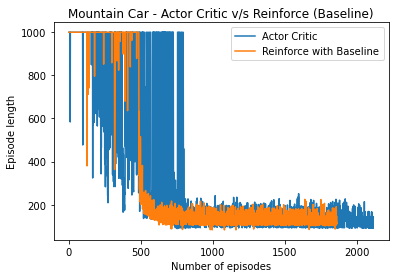

In [347]:
plt.figure()
reinforce_ep1 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 380, 893, 1000, 1000, 1000, 1000, 790, 712, 1000, 1000, 1000, 1000, 1000, 1000, 742, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 796, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 852, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 970, 858, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 363, 547, 654, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 867, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 962, 824, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 958, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 899, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 953, 680, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 916, 636, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 839, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 962, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 878, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 337, 545, 632, 293, 269, 309, 256, 253, 214, 296, 516, 440, 201, 337, 348, 346, 341, 300, 210, 211, 302, 305, 273, 313, 382, 180, 206, 224, 231, 198, 206, 257, 213, 161, 218, 220, 161, 234, 206, 250, 196, 258, 156, 160, 205, 214, 266, 200, 244, 230, 205, 238, 155, 153, 199, 242, 214, 225, 247, 214, 209, 151, 204, 231, 193, 252, 224, 148, 186, 222, 208, 225, 212, 147, 206, 222, 136, 157, 163, 237, 242, 134, 134, 136, 146, 157, 142, 146, 144, 146, 140, 169, 221, 133, 135, 172, 156, 153, 151, 132, 153, 148, 185, 223, 132, 215, 129, 130, 147, 130, 150, 149, 145, 173, 132, 175, 132, 129, 178, 131, 162, 177, 138, 181, 149, 135, 177, 185, 138, 125, 133, 182, 194, 139, 139, 188, 185, 146, 186, 175, 106, 135, 152, 157, 152, 123, 180, 140, 199, 140, 163, 139, 130, 140, 116, 143, 148, 142, 211, 132, 137, 131, 144, 169, 135, 108, 113, 189, 138, 150, 153, 152, 109, 181, 139, 172, 139, 129, 195, 133, 152, 132, 138, 184, 187, 106, 108, 136, 150, 135, 164, 134, 158, 197, 106, 137, 112, 133, 110, 135, 134, 183, 133, 110, 143, 177, 169, 108, 134, 132, 109, 171, 153, 134, 108, 196, 159, 197, 129, 129, 202, 89, 133, 158, 109, 141, 217, 88, 108, 141, 136, 137, 193, 154, 189, 144, 106, 188, 182, 107, 139, 176, 134, 159, 154, 151, 174, 143, 135, 114, 132, 206, 137, 157, 136, 111, 167, 110, 170, 154, 109, 171, 108, 136, 150, 136, 183, 136, 185, 141, 135, 163, 109, 110, 148, 149, 175, 136, 198, 131, 136, 176, 132, 171, 180, 159, 136, 133, 141, 136, 125, 193, 105, 170, 108, 134, 110, 109, 137, 164, 178, 184, 85, 137, 105, 144, 105, 107, 169, 150, 135, 149, 110, 132, 130, 161, 145, 165, 152, 135, 110, 132, 162, 147, 109, 166, 118, 133, 131, 110, 173, 132, 129, 140, 161, 118, 151, 148, 134, 180, 137, 133, 130, 164, 190, 135, 159, 157, 106, 109, 135, 170, 151, 136, 149, 154, 157, 110, 136, 172, 179, 106, 136, 107, 133, 132, 204, 136, 132, 132, 108, 205, 108, 161, 104, 153, 166, 105, 159, 138, 151, 137, 110, 146, 149, 109, 134, 145, 162, 153, 136, 110, 170, 110, 132, 194, 107, 134, 186, 162, 138, 159, 137, 164, 136, 202, 178, 139, 137, 110, 139, 169, 166, 108, 168, 136, 133, 108, 195, 154, 105, 109, 177, 138, 106, 137, 121, 216, 139, 138, 106, 105, 150, 130, 110, 107, 109, 109, 127, 113, 109, 187, 109, 107, 105, 106, 146, 112, 196, 103, 174, 146, 208, 140, 106, 105, 150, 112, 104, 106, 147, 132, 148, 107, 108, 109, 109, 114, 111, 190, 105, 172, 145, 170, 135, 151, 135, 109, 131, 113, 114, 137, 108, 188, 129, 154, 156, 108, 193, 103, 103, 104, 105, 132, 184, 84, 113, 111, 115, 129, 112, 188, 103, 128, 181, 105, 152, 152, 83, 132, 142, 107, 108, 113, 135, 181, 103, 187, 108, 148, 109, 111, 112, 184, 109, 151, 132, 110, 168, 111, 175, 110, 163, 106, 133, 131, 138, 184, 110, 108, 145, 132, 166, 103, 151, 104, 108, 112, 106, 168, 131, 111, 109, 137, 111, 110, 163, 109, 108, 112, 106, 132, 143, 114, 107, 109, 200, 141, 106, 143, 105, 128, 111, 170, 106, 103, 145, 154, 110, 142, 114, 111, 165, 144, 103, 146, 130, 129, 197, 152, 110, 103, 167, 83, 110, 106, 112, 161, 130, 106, 129, 140, 146, 106, 143, 107, 112, 116, 110, 113, 143, 144, 170, 150, 106, 107, 111, 187, 105, 107, 105, 109, 128, 112, 110, 108, 139, 108, 120, 113, 175, 115, 109, 184, 105, 143, 129, 193, 107, 148, 108, 103, 103, 154, 104, 103, 152, 112, 109, 107, 137, 136, 197, 132, 104, 130, 105, 112, 136, 145, 143, 111, 148, 144, 141, 104, 141, 149, 109, 190, 105, 150, 154, 83, 134, 132, 113, 173, 168, 160, 111, 111, 105, 132, 112, 129, 108, 168, 183, 152, 134, 152, 134, 149, 150, 113, 133, 148, 132, 170, 106, 172, 134, 106, 143, 191, 135, 133, 148, 154, 108, 107, 184, 110, 108, 107, 105, 106, 147, 107, 147, 131, 194, 174, 136, 133, 132, 146, 105, 106, 165, 106, 149, 107, 113, 166, 104, 141, 107, 177, 107, 131, 169, 104, 106, 144, 112, 104, 178, 163, 104, 150, 153, 135, 167, 134, 133, 107, 131, 123, 130, 114, 179, 151, 145, 131, 168, 107, 112, 109, 114, 136, 138, 188, 110, 109, 146, 187, 108, 108, 110, 130, 150, 156, 131, 105, 111, 182, 131, 107, 112, 202, 149, 132, 180, 157, 87, 133, 132, 148, 172, 108, 108, 154, 105, 133, 143, 112, 110, 113, 158, 107, 109, 137, 163, 106, 148, 110, 173, 132, 151, 144, 106, 149, 111, 190, 156, 106, 109, 107, 169, 187, 136, 106, 134, 150, 109, 147, 181, 135, 133, 131, 106, 161, 131, 145, 112, 196, 151, 134, 106, 111, 112, 168, 104, 110, 108, 141, 202, 125, 105, 133, 146, 133, 131, 149, 146, 116, 162, 132, 171, 133, 107, 148, 106, 181, 104, 181, 103, 110, 132, 151, 148, 110, 181, 109, 104, 132, 131, 113, 105, 107, 184, 130, 113, 111, 113, 110, 106, 109, 141, 130, 146, 121, 187, 150, 163, 107, 157, 107, 153, 154, 135, 132, 165, 132, 131, 108, 112, 115, 107, 161, 129, 106, 143, 110, 184, 112, 155, 130, 109, 138, 111, 135, 114, 110, 110, 185, 183, 130, 163, 104, 113, 104, 103, 103, 112, 111, 148, 137, 176, 107, 108, 108, 104, 184, 110, 147, 162, 161, 195, 135, 168, 135, 105, 110, 133, 112, 114, 108, 110, 172, 176, 152, 112, 111, 142, 131, 191, 107, 107, 112, 130, 107, 137, 185, 103, 107, 183, 110, 112, 105, 152, 148, 108, 110, 111, 113, 105, 141, 106, 112, 106, 113, 200, 153, 110, 106, 107, 109, 112, 191, 157, 104, 103, 128, 152, 147, 110, 114, 104, 143, 171, 103, 112, 139, 174, 145, 111, 131, 167, 111, 143, 110, 153, 149, 159, 159, 154, 103, 134, 111, 104, 109, 173, 104, 105, 112, 182, 112, 110, 108, 107, 166, 130, 142, 175, 131, 131, 108, 129, 178, 107, 129, 167, 110, 149, 107, 154, 179, 134, 164, 112, 177, 111, 107, 111, 110, 150, 170, 110, 104, 110, 106, 104, 143, 165, 151, 182, 109, 110, 106, 150, 131, 171, 134, 108, 132, 176, 104, 112, 106, 122, 109, 140, 113, 129, 181, 110, 107, 112, 137, 173, 129, 103, 109, 137, 146, 142, 151, 143, 108, 176, 110, 149, 145, 170, 106, 113, 183, 106, 111, 151, 103, 112, 151, 177, 135, 112, 113, 109, 148, 130, 165, 112, 108, 129, 111, 178, 144, 104, 225, 109, 132, 135, 131, 111, 110, 141, 216, 133, 132, 145, 107, 111, 110, 111, 109, 112, 112, 140, 107, 112, 111, 148, 112, 182, 186, 157, 103, 103, 85, 109, 148, 144, 111, 141, 129, 178, 147, 103, 106, 131, 114, 114, 144, 109, 163, 145, 109, 103, 146, 106, 111, 106, 106, 109, 201, 168, 113, 146, 109, 163, 104, 104, 158, 104, 142, 110, 114, 180, 112, 165, 102, 102, 103, 146, 114, 104, 108, 111, 108, 141, 107, 110, 108, 182, 173, 156, 104, 110, 106, 107, 162, 112, 149, 129, 149, 142, 130, 106, 128, 139, 105, 114, 130, 145, 108, 111, 113, 111, 128, 224, 131, 143, 109, 108, 146, 114, 148, 110, 114, 107, 135, 192, 113, 201, 152, 105, 109, 105, 145, 104, 112, 107, 148, 131, 206, 112, 103, 105, 103, 104, 103, 115, 114, 112, 109, 148, 106, 109, 110, 144, 105, 109, 105, 107, 165, 110, 111, 125, 173, 157, 151, 105, 103, 175, 103, 155, 145, 131, 105, 108, 106, 103, 108, 140, 136, 108, 106, 166, 142, 112, 112, 105, 109, 137, 106, 112, 105, 110, 105, 111, 185, 139, 149, 104, 148, 107, 173, 103, 178, 184, 131, 170, 103, 108, 131, 103, 173, 149, 87, 103, 108, 107, 112, 107, 112, 111, 191, 106, 147, 113, 114, 115]
plt.plot(np.arange(len(episode_length)), episode_length, label='Actor Critic')
plt.plot(np.arange(len(reinforce_ep1)), reinforce_ep1, label='Reinforce with Baseline')
plt.xlabel('Number of episodes')
plt.ylabel('Episode length')
plt.title('Mountain Car - Actor Critic v/s Reinforce (Baseline)')
plt.legend()
# plt.ylim([-100, 1000])
print('graph_mountaincar_actor-critic_policy_param'+str(policy_step_size)+'_AND_v_param'+str(valueFunction_step_size))
# plt.savefig('graph_mountaincar_actor-critic'+str(valueFunction_step_size))

In [ ]:
# str(episode_length)
# ep1 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 584, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 477, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 849, 1000, 1000, 983, 1000, 1000, 1000, 1000, 1000, 324, 1000, 570, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 582, 1000, 1000, 1000, 1000, 1000, 850, 644, 944, 872, 999, 1000, 1000, 623, 1000, 1000, 1000, 1000, 796, 1000, 864, 1000, 565, 1000, 1000, 827, 1000, 1000, 1000, 937, 768, 1000, 896, 1000, 645, 872, 650, 607, 1000, 1000, 614, 1000, 1000, 627, 972, 567, 564, 607, 343, 749, 464, 1000, 1000, 1000, 722, 914, 1000, 1000, 1000, 1000, 1000, 563, 788, 668, 1000, 1000, 546, 538, 690, 572, 655, 1000, 1000, 414, 387, 543, 1000, 1000, 283, 839, 1000, 1000, 646, 569, 485, 583, 1000, 419, 588, 504, 464, 333, 378, 284, 241, 593, 1000, 209, 581, 779, 564, 454, 486, 466, 460, 491, 537, 1000, 642, 1000, 1000, 464, 844, 1000, 691, 1000, 1000, 824, 1000, 524, 1000, 1000, 1000, 1000, 1000, 1000, 780, 487, 339, 498, 489, 401, 429, 346, 307, 390, 306, 284, 412, 614, 1000, 294, 1000, 573, 649, 1000, 284, 478, 1000, 389, 1000, 1000, 867, 564, 483, 539, 565, 550, 544, 1000, 1000, 442, 848, 1000, 1000, 1000, 1000, 957, 420, 566, 685, 1000, 322, 985, 1000, 762, 1000, 1000, 396, 1000, 828, 997, 834, 1000, 395, 1000, 320, 1000, 584, 1000, 1000, 580, 1000, 739, 737, 677, 290, 387, 464, 167, 298, 327, 166, 433, 171, 324, 173, 263, 201, 173, 201, 175, 175, 253, 248, 255, 870, 546, 469, 975, 497, 1000, 470, 1000, 932, 1000, 462, 419, 852, 724, 1000, 1000, 1000, 1000, 528, 419, 276, 348, 697, 1000, 1000, 1000, 315, 418, 983, 1000, 1000, 749, 699, 837, 416, 624, 1000, 680, 424, 1000, 404, 584, 637, 1000, 1000, 1000, 245, 331, 621, 1000, 1000, 688, 1000, 1000, 1000, 628, 270, 267, 260, 422, 635, 1000, 1000, 1000, 461, 560, 761, 399, 494, 638, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 808, 345, 338, 1000, 391, 635, 348, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 519, 255, 475, 505, 1000, 1000, 665, 1000, 169, 262, 256, 325, 352, 1000, 1000, 1000, 528, 343, 346, 271, 535, 220, 1000, 1000, 1000, 1000, 325, 555, 1000, 364, 1000, 1000, 1000, 1000, 457, 136, 279, 1000, 1000, 1000, 1000, 176, 260, 616, 205, 259, 484, 345, 140, 747, 196, 182, 326, 1000, 1000, 1000, 1000, 902, 137, 335, 242, 491, 749, 290, 1000, 1000, 1000, 1000, 1000, 169, 367, 204, 193, 195, 199, 294, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 801, 194, 251, 133, 191, 255, 197, 259, 263, 255, 188, 199, 263, 1000, 1000, 1000, 284, 1000, 183, 343, 1000, 1000, 641, 1000, 1000, 1000, 309, 324, 437, 1000, 180, 193, 260, 195, 1000, 1000, 1000, 376, 196, 189, 1000, 537, 1000, 277, 194, 244, 186, 1000, 741, 192, 1000, 186, 309, 508, 1000, 1000, 470, 194, 1000, 1000, 1000, 1000, 189, 169, 445, 933, 242, 250, 793, 1000, 1000, 1000, 1000, 732, 361, 189, 184, 1000, 221, 1000, 193, 183, 1000, 1000, 1000, 253, 1000, 1000, 459, 184, 1000, 1000, 399, 243, 1000, 192, 1000, 1000, 540, 1000, 194, 1000, 1000, 370, 176, 1000, 1000, 1000, 1000, 1000, 1000, 187, 179, 1000, 1000, 1000, 1000, 567, 180, 1000, 1000, 190, 181, 183, 1000, 1000, 1000, 1000, 190, 1000, 1000, 1000, 850, 174, 175, 1000, 1000, 322, 181, 178, 1000, 1000, 1000, 1000, 1000, 1000, 237, 176, 181, 1000, 1000, 190, 180, 183, 1000, 171, 1000, 363, 156, 352, 168, 153, 167, 160, 162, 164, 165, 167, 168, 166, 94, 314, 159, 169, 167, 216, 170, 92, 101, 126, 172, 174, 175, 89, 269, 173, 1000, 1000, 1000, 309, 171, 179, 179, 90, 1000, 185, 175, 1000, 1000, 1000, 1000, 1000, 1000, 187, 92, 170, 178, 107, 119, 198, 1000, 1000, 181, 97, 273, 176, 92, 1000, 1000, 181, 90, 147, 172, 93, 178, 1000, 374, 180, 460, 159, 158, 94, 104, 138, 94, 135, 177, 180, 156, 173, 227, 90, 158, 189, 175, 159, 179, 111, 188, 160, 94, 138, 193, 156, 209, 166, 94, 134, 227, 169, 169, 92, 136, 160, 189, 175, 151, 184, 94, 141, 163, 99, 139, 92, 138, 145, 117, 109, 129, 190, 217, 174, 105, 133, 158, 102, 143, 178, 95, 140, 194, 170, 96, 131, 103, 139, 189, 174, 160, 180, 96, 138, 154, 158, 133, 187, 113, 139, 93, 140, 109, 127, 158, 192, 92, 134, 195, 217, 178, 97, 140, 182, 231, 99, 143, 185, 99, 140, 167, 94, 127, 113, 162, 100, 133, 196, 176, 195, 173, 175, 173, 138, 161, 93, 138, 197, 205, 230, 182, 114, 129, 135, 134, 173, 183, 184, 155, 175, 138, 215, 210, 134, 180, 196, 181, 141, 194, 118, 137, 189, 108, 138, 171, 129, 95, 139, 98, 179, 190, 191, 134, 131, 112, 138, 94, 186, 193, 198, 131, 206, 116, 121, 111, 137, 192, 122, 179, 141, 194, 116, 170, 133, 97, 143, 183, 170, 158, 110, 135, 133, 180, 99, 139, 95, 143, 165, 190, 134, 184, 101, 141, 178, 172, 133, 102, 139, 112, 170, 142, 171, 185, 99, 139, 180, 173, 141, 98, 138, 109, 170, 138, 191, 177, 152, 96, 124, 133, 242, 184, 176, 188, 129, 168, 183, 140, 107, 138, 105, 118, 135, 95, 132, 172, 196, 181, 162, 184, 141, 177, 184, 139, 178, 103, 132, 132, 168, 198, 109, 136, 161, 98, 142, 159, 193, 102, 139, 95, 128, 140, 96, 140, 93, 133, 205, 96, 177, 190, 142, 94, 143, 185, 98, 140, 216, 107, 169, 137, 96, 144, 94, 138, 177, 96, 139, 193, 96, 128, 114, 137, 178, 182, 97, 140, 171, 197, 100, 142, 179, 181, 184, 189, 135, 98, 137, 179, 108, 134, 196, 185, 136, 193, 192, 105, 142, 195, 178, 143, 93, 130, 132, 102, 139, 108, 134, 93, 138, 179, 189, 182, 94, 137, 168, 173, 172, 95, 133, 143, 200, 97, 132, 206, 190, 191, 166, 168, 234, 203, 177, 98, 139, 127, 140, 114, 169, 196, 195, 129, 98, 137, 137, 93, 124, 212, 103, 140, 104, 139, 235, 189, 177, 190, 175, 208, 109, 140, 100, 138, 179, 115, 144, 92, 138, 180, 182, 99, 142, 183, 193, 144, 166, 210, 111, 145, 173, 204, 176, 201, 128, 176, 138, 169, 183, 145, 165, 93, 139, 137, 182, 179, 188, 102, 136, 140, 181, 184, 137, 172, 171, 138, 173, 99, 132, 94, 139, 140, 195, 97, 143, 101, 142, 166, 102, 133, 98, 140, 92, 144, 207, 109, 207, 173, 116, 209, 172, 145, 112, 121, 143, 111, 122, 141, 100, 142, 101, 136, 103, 138, 94, 143, 183, 176, 180, 108, 128, 189, 107, 143, 198, 112, 139, 185, 191, 186, 179, 121, 138, 132, 139, 194, 180, 139, 98, 143, 161, 160, 93, 140, 171, 149, 183, 115, 212, 175, 109, 138, 137, 139, 191, 124, 174, 139, 97, 140, 198, 202, 184, 96, 139, 102, 145, 133, 93, 129, 130, 116, 132, 119, 166, 181, 201, 169, 141, 94, 141, 196, 96, 139, 187, 95, 144, 182, 133, 184, 205, 187, 188, 139, 96, 138, 95, 145, 101, 138, 130, 139, 176, 93, 136, 179, 202, 167, 96, 138, 143, 173, 208, 178, 188, 119, 129, 106, 140, 133, 175, 95, 141, 204, 112, 139, 174, 96, 143, 144, 97, 144, 164, 170, 178, 100, 125, 100, 140, 138, 162, 183, 174, 138, 195, 94, 96, 140, 139, 93, 137, 101, 140, 118, 140, 93, 144, 205, 171, 211, 122, 95, 143, 170, 139, 190, 218, 179, 175, 103, 142, 100, 139, 142, 177, 118, 144, 159, 174, 94, 144, 223, 179, 98, 144, 190, 102, 141, 182, 112, 140, 99, 142, 179, 192, 95, 141, 144, 167, 137, 93, 104, 132, 96, 136, 177, 145, 103, 186, 93, 139, 144, 103, 140, 181, 191, 188, 192, 228, 197, 104, 98, 143, 141, 200, 96, 140, 142, 177, 94, 97, 140, 135, 104, 139, 93, 140, 121, 99, 145, 100, 139, 93, 141, 177, 182, 106, 136, 94, 145, 109, 137, 168, 176, 141, 179, 184, 190, 196, 126, 95, 145, 99, 137, 98, 138, 144, 99, 146, 153, 170, 109, 139, 169, 94, 199, 197, 143, 96, 94, 145, 141, 95, 140, 99, 141, 92, 142, 142, 168, 100, 140, 163, 220, 205, 187, 183, 97, 97, 142, 98, 140, 93, 140, 191, 93, 140, 143, 133, 94, 136, 99, 143, 184, 177, 94, 137, 179, 182, 183, 105, 144, 143, 192, 178, 203, 94, 93, 142, 142, 96, 97, 139, 144, 102, 145, 111, 189, 93, 144, 180, 182, 143, 176, 228, 99, 196, 178, 117, 145, 186, 237, 113, 251, 102, 186, 195, 121, 143, 143, 96, 145, 191, 142, 95, 142, 96, 140, 143, 94, 195, 187, 94, 137, 96, 147, 145, 94, 141, 98, 144, 174, 193, 93, 131, 171, 94, 139, 101, 141, 99, 139, 190, 182, 142, 98, 190, 94, 145, 141, 92, 93, 139, 143, 171, 94, 194, 177, 97, 141, 184, 99, 141, 94, 142, 142, 98, 95, 139, 141, 190, 142, 98, 94, 141, 177, 179, 144, 140, 171, 175, 94, 209, 194, 189, 95, 94, 142, 224, 94, 104, 142, 106, 139, 208, 103, 141, 208, 98, 146, 99, 136, 142, 146, 94, 144, 174, 220, 95, 93, 92, 140, 143, 182, 94, 133, 141, 182, 106, 182, 180, 187, 95, 143, 143, 140, 182, 206, 174, 94, 175, 178, 141, 184, 94, 143, 140, 104, 144, 93, 142, 138, 163, 94, 189, 184, 92, 143, 94, 103, 142, 146, 92, 142, 127, 194, 100, 144, 186, 145, 185, 104, 94, 142, 111, 146, 105, 92, 145, 141, 189, 95, 92, 145, 145, 187, 181, 101, 145, 185, 109, 145, 95, 143, 94, 94, 139, 141, 93, 141, 144, 92, 144, 163, 114, 140, 96, 96, 187, 92, 141, 96, 95, 140, 142, 91, 94, 140, 141, 143, 98, 204, 180, 112, 94, 142, 185, 146, 179, 176, 97, 96, 133, 93, 141, 210, 107, 95, 146, 137, 144, 195, 177, 105, 94, 139, 142, 141, 93, 215, 97, 97, 141, 144, 143, 175, 105, 143, 93, 95, 135, 143, 196, 95, 144, 93, 211, 178, 167, 196, 98, 185, 225, 96, 147, 176, 94, 146, 92, 145, 95, 140, 92, 143, 141, 208, 93, 92, 144, 108, 132, 97, 143, 93, 143, 141, 184, 221, 96, 142, 95, 195, 182, 96, 96, 137, 144, 95, 143, 97, 98, 137, 130, 93, 138, 177, 146, 94, 143, 199, 121, 166, 206, 109, 93, 94, 141, 143, 143, 213, 97, 93, 143, 191, 174, 195, 227, 169, 200, 141, 198, 123, 173, 123, 177, 211, 191, 97, 97, 145, 142, 102, 120, 146, 141, 193, 141, 95, 145, 143, 164, 98, 170, 92, 144, 92, 140, 99, 92, 142, 142, 144, 143, 165, 97, 95, 101, 146, 92, 141, 91, 141, 92, 93, 140, 93, 138, 183, 99, 141, 143, 165, 193, 142, 140, 199, 99, 98, 104, 99, 144, 145, 97, 144, 92, 188, 192, 93, 99, 146, 100, 112, 141, 144, 142, 104, 101, 142, 135, 92, 95, 146, 102, 145, 144, 145, 188, 146, 164, 170, 204, 177, 160, 169, 97, 177, 198, 179, 187, 169, 183, 175, 146, 142, 172, 175, 186, 100, 93, 145, 144, 166, 97, 95, 142, 104, 91, 146, 142, 101, 92, 92, 140, 143, 94, 91, 138, 128, 145, 214, 141, 145, 108, 93, 95, 167, 93, 141, 105, 144, 92, 142, 104, 93, 132, 95, 94, 143, 145, 143, 144, 141, 98, 95, 167, 145, 129, 92, 95, 169, 92, 143, 166, 92, 143, 92, 94, 140, 93, 141, 93, 140, 140, 145, 96, 91, 140, 140, 146, 167, 92, 91, 165, 93, 94, 142, 95, 145, 142, 90, 144, 142]

In [340]:
actions_total = []
for i in range(len(episode_length)):
    actions_total.append(sum(episode_length[:i+1]))

Text(0, 0.5, 'Total Episodes')

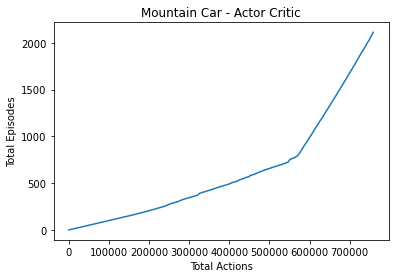

In [342]:
plt.figure()
plt.plot(actions_total, np.arange(len(episode_length)))
plt.title('Mountain Car - Actor Critic')
plt.xlabel('Total Actions')
plt.ylabel('Total Episodes')